# ARIMA Model for Time Series Forecasting
El siguiente código es parte del articulo [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/), el cual utilizé como base para el análsis inicial del mis series de tiempo. El ejemplo original está guardado en el directorio *scripts* junto con el conjunto de datos.

In [38]:
from pandas import read_csv, datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

In [92]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [110]:
series = read_csv('datasets/stationary/26479.csv', index_col=0, header=None, names=['vol'])
print(series.shape)
series.head(10)

(288, 1)


,vol
0,10
1,5
2,20
3,10
4,15
5,21
6,7
7,11
8,21
9,12


## Gráfico de Serie Temporal
La serie temporal que usé en este caso fu previamente clasificada como *stationary* usando Augmented Dickey-fuller test. La forma que presenta la serie temporal es la siguiente:

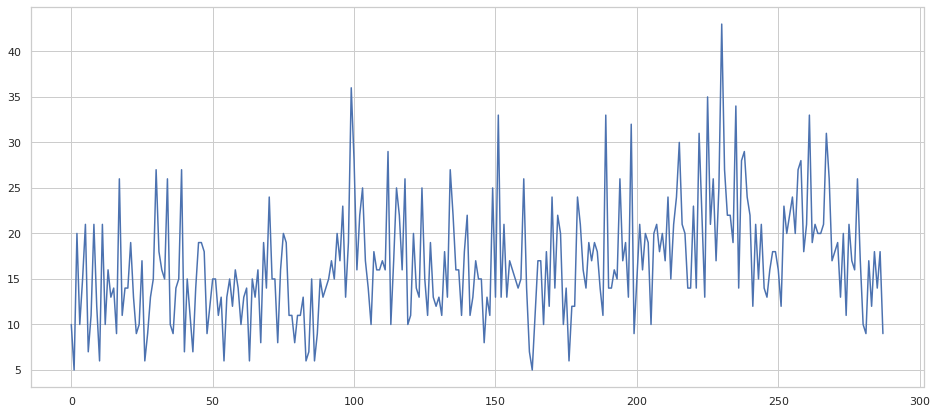

In [27]:
plt.figure(figsize=(16,7))
plt.plot(series.index, series.values)

## Gráfico de autocorrelación
Este gráfico está diseñado para mostrar si los elementos de la serie están correlacionados positivamente, negativamente o eran independientes una de otra. 
En el documento [Autocorrelation Plots: Graphical Technique for Statistical Data](https://www.dummies.com/programming/big-data/data-science/autocorrelation-plots-graphical-technique-for-statistical-data/) 

* **Eje vertical**: valor AutoCorrelation Function (ACF) en un rango desde -1 hasta 1.
* **Eje Horizontal**: El tamaño de los **lags** entre los elementos de la serie de tiempo.

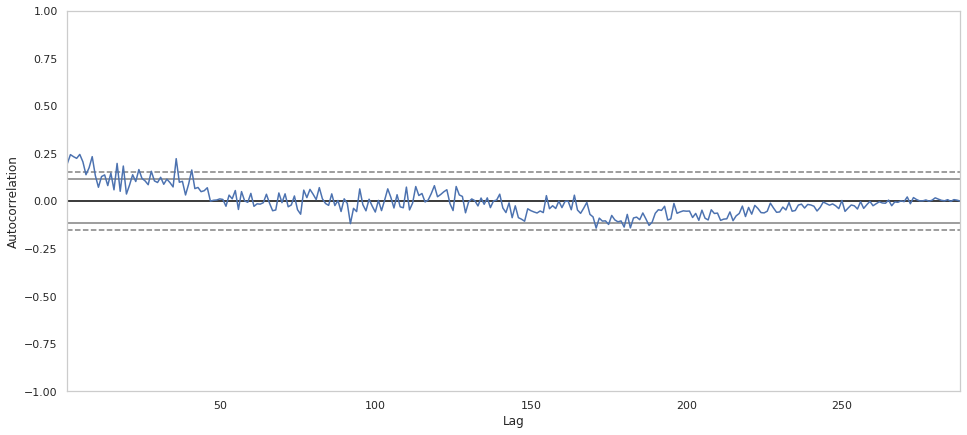

In [31]:
plt.figure(figsize=(16,7))
autocorrelation_plot(series)
# plt.plot()

Este gráfico de la librería *pandas* tiene pocos parametros para ser modificados y es necesario pasar parametros hasta el objeto de *Mathplotlib** del que hereda, resulta más sencillo usar directamente *mathplotlib* para graficar el ACF.

## ACF - AutoCorrelation Function
Describe la correlación que existe entre los elementos de la serie y los elementos correspondientes periodos de tiempo previos. Para encontrar los valores de la función y graficarlo se definió la función:

In [52]:
def get_autocorrelation_function(dataset, nlags=288):
    ## Confidence intervals
    inf_confidence = -1.96/np.sqrt(len(dataset))
    sup_confidence = 1.96/np.sqrt(len(dataset))
    
    print('Invervalo de confianza superior: {0}'.format(sup_confidence))
    
    lag_acf = acf(dataset, nlags=nlags, fft=False)
    
    nucount=0
    for autocorr in lag_acf:
        print('Lag {0} = {1}'.format(nucount, autocorr))
        nucount+=1
    
    #Plot PACF:
    plt.figure(figsize=(16, 7))
    plt.plot(lag_acf,marker='o')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=inf_confidence, linestyle='--',color='gray')
    plt.axhline(y=sup_confidence, linestyle='--',color='gray')
    
    plt.title('Autocorrelation Function')
    plt.xlabel('number of lags')
    plt.ylabel('correlation')
    plt.tight_layout()

Invervalo de confianza superior: 0.11549410759380277
Lag 0 = 1.0
Lag 1 = 0.19678997459656206
Lag 2 = 0.24397298611627713
Lag 3 = 0.23316631330539506
Lag 4 = 0.22436078116949495
Lag 5 = 0.2450354979983082
Lag 6 = 0.20638147725675926
Lag 7 = 0.13846418376990324
Lag 8 = 0.17515546518323813
Lag 9 = 0.23335962878468516
Lag 10 = 0.13409113138977743
Lag 11 = 0.07238555709849753
Lag 12 = 0.1287150461642737
Lag 13 = 0.13734324329164632
Lag 14 = 0.08115630415795314
Lag 15 = 0.1468752841355254
Lag 16 = 0.05899741832739572
Lag 17 = 0.19775555321358998
Lag 18 = 0.05122591563964588
Lag 19 = 0.18400294605489018
Lag 20 = 0.03684345751261213
Lag 21 = 0.08409838115075918
Lag 22 = 0.13824322965314112
Lag 23 = 0.10255124427251662
Lag 24 = 0.16540861788214675
Lag 25 = 0.11877855131522026
Lag 26 = 0.10578723794094388
Lag 27 = 0.08585888486621863
Lag 28 = 0.15655095979258446
Lag 29 = 0.10590373350636322
Lag 30 = 0.09740692753407558
Lag 31 = 0.12483270444670373
Lag 32 = 0.08814262845681001
Lag 33 = 0.11497079

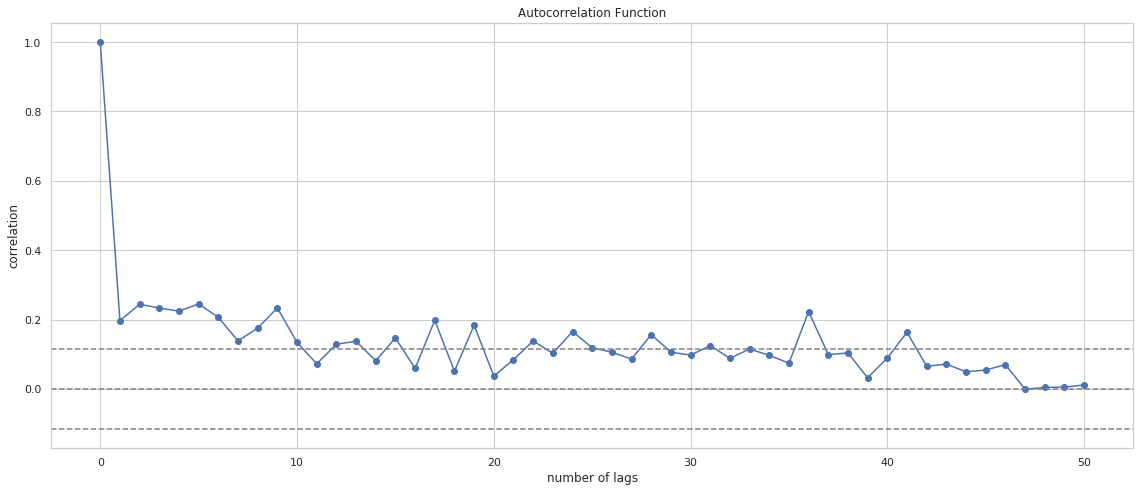

In [124]:
get_autocorrelation_function(series, 50)

El gráfico muestra relaciones significativas hasta el lag 10, este es el lag después del cual el gráfico corta el intervalo de confianza superior por primera vez, por lo que el parámetro **q** del modelo ARIMA se toma como diez (10), esto representa a la subclase del modelo **MA**.

## PACF - Partial AutoCorrelation Function
PACF representa la correlación de un valor de la serie con los valores de periodos de tiempo anteriores pero sin tener en cuenta las características descritas por los *lags* previos, se usa para evaluar los modelos **AR - AutoRegressive Model**, debido a que el modelo **AR** se construye con la correlación entre periodos de tiempo. Para esta evaluación se definió la siguiente función:

In [56]:
def get_partial_autocorrelation_function(dataset, nlags=287):
    ## Confidence intervals
    inf_confidence = -1.96/np.sqrt(len(dataset))
    sup_confidence = 1.96/np.sqrt(len(dataset))
      
    print('Invervalo de confianza superior: {0}'.format(sup_confidence))
    
    lag_pacf = pacf(dataset, nlags=nlags, method='ols')

    nucount=0
    for autocorr in lag_pacf:
        print('Lag {0} = {1}'.format(nucount, autocorr))
        nucount+=1
    
    #Plot PACF:
    plt.figure(figsize=(16, 7))
    plt.plot(lag_pacf, marker='o')
    plt.axhline(y=0,linestyle='--', color='gray')
    plt.axhline(y=inf_confidence, linestyle='--', color='gray')
    plt.axhline(y=sup_confidence, linestyle='--', color='gray')
    
    plt.title('Partial Autocorrelation Function')
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.tight_layout()

Invervalo de confianza superior: 0.11549410759380277
Lag 0 = 1.0
Lag 1 = 0.19784194260817048
Lag 2 = 0.21580847708538325
Lag 3 = 0.16749553855016244
Lag 4 = 0.13332776751788616
Lag 5 = 0.1413762092748362
Lag 6 = 0.07930614277809672
Lag 7 = -0.008319159149432279
Lag 8 = 0.0462616817656573
Lag 9 = 0.12423356496169541
Lag 10 = -0.007476858566100808


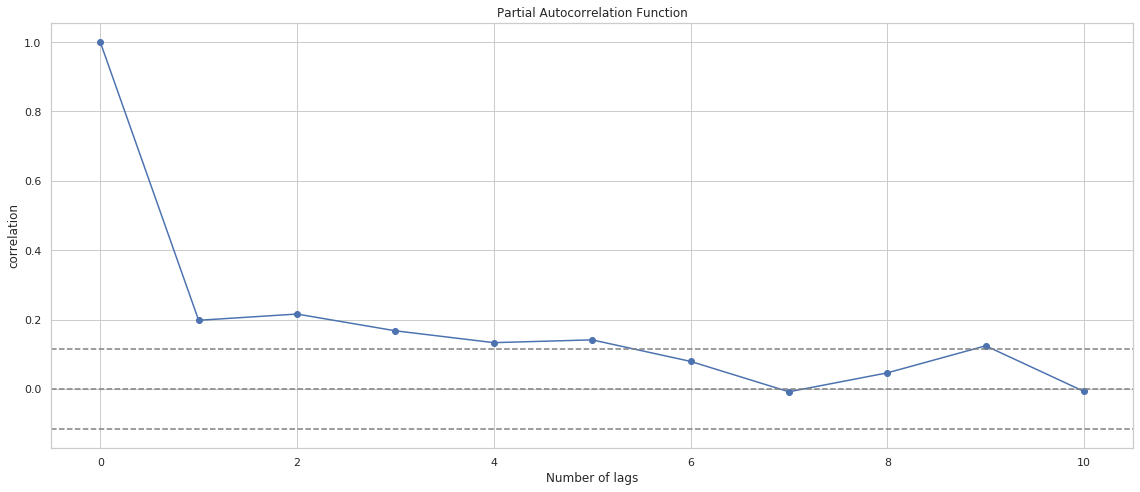

In [126]:
get_partial_autocorrelation_function(series, 10)

En este caso las releaciones significantes se presentan hasta el *lag* 5, por lo que se usará ese valor como parámetro *p* que representa la subclase del model *AR*.

## Ajuste del modelo ARIMA



In [89]:
p = 5
d = 0
q = 0

model = ARIMA(series, order=(q,d,p))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    vol   No. Observations:                  288
Model:                     ARMA(0, 5)   Log Likelihood                -919.028
Method:                       css-mle   S.D. of innovations              5.881
Date:                Thu, 06 Aug 2020   AIC                           1852.055
Time:                        15:48:43   BIC                           1877.696
Sample:                             0   HQIC                          1862.331
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7170      0.563     29.703      0.000      15.614      17.820
ma.L1.vol      0.0874      0.060      1.468      0.142      -0.029       0.204
ma.L2.vol      0.1645      0.061      2.695      0.0

Text(0.5, 1.0, 'ARIMA(5,0,0)')

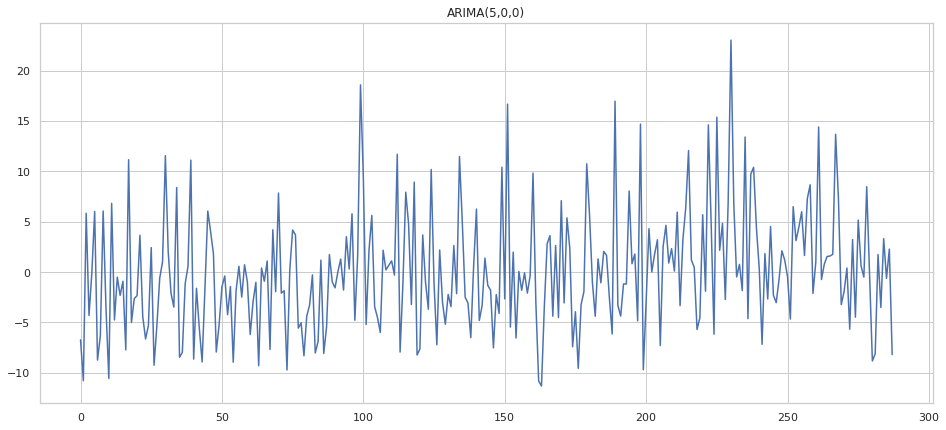

In [90]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
plt.figure(figsize=(16, 7))
plt.plot(residuals)
plt.title('ARIMA({},{},{})'.format(p,d,q))

# plt.plot(lag_pacf, marker='o')
# plt.axhline(y=0,linestyle='--', color='gray')
# plt.axhline(y=inf_confidence, linestyle='--', color='gray')
# plt.axhline(y=sup_confidence, linestyle='--', color='gray')

# plt.title('Partial Autocorrelation Function')
# plt.xlabel('Number of lags')
# plt.ylabel('correlation')
# plt.tight_layout()

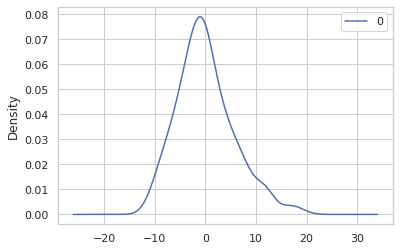

                0
count  288.000000
mean     0.058815
std      5.644227
min    -11.083972
25%     -3.707592
50%     -0.641403
75%      3.240410
max     19.018521


In [86]:
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [95]:
def arima_forescasting(dataset, p, d, q):
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.figure(figsize=(16, 7))
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    return error

In [100]:
arima_MSE = []

In [101]:
arima_MSE.append(arima_forescasting(series,5,0,10))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ValueError: On entry to DLASCL parameter number 4 had an illegal value

Test MSE: 39.342


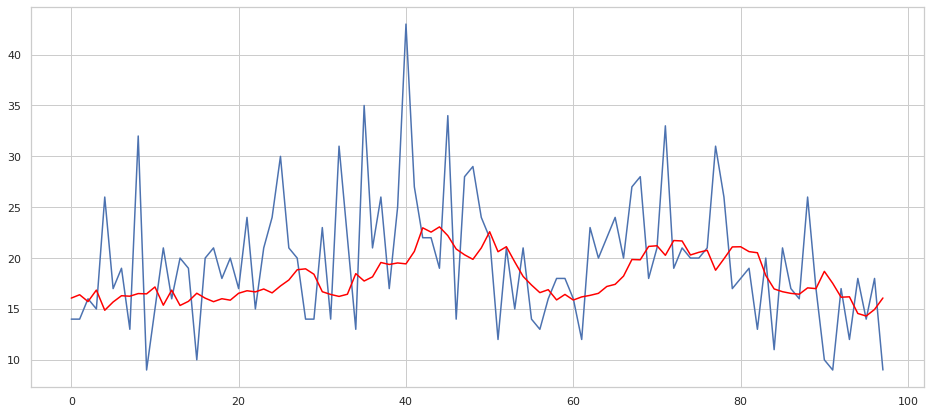

In [97]:
arima_MSE.append(arima_forescasting(series,5,0,0))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 38.735


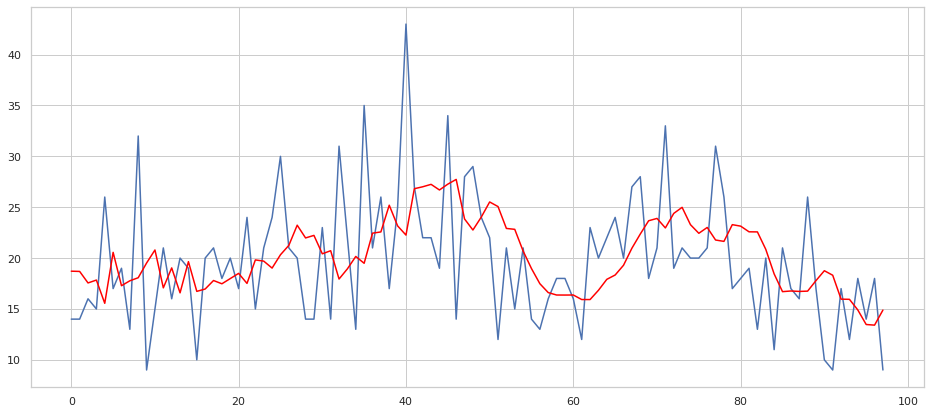

In [98]:
arima_MSE.append(arima_forescasting(series,5,1,0))

Test MSE: 42.604


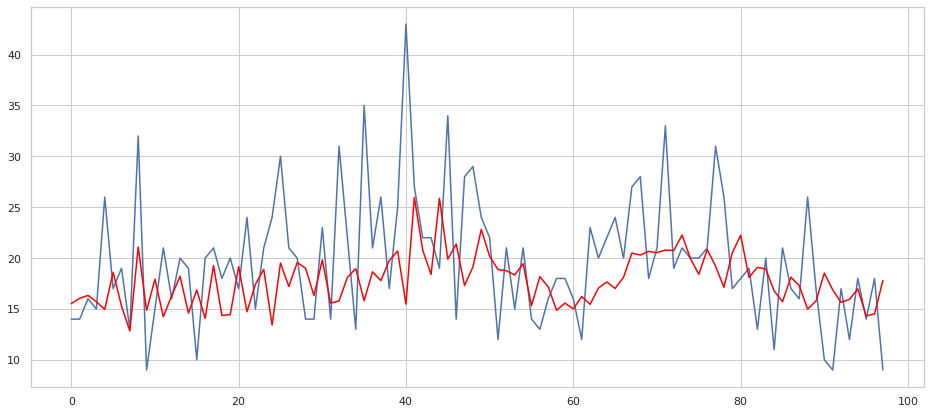

In [102]:
arima_MSE.append(arima_forescasting(series,0,0,10))

In [103]:
arima_MSE.append(arima_forescasting(series,5,1,10))

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [104]:
arima_MSE.append(arima_forescasting(series,5,1,5))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [105]:
arima_MSE.append(arima_forescasting(series,5,0,5))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: invalid value encountered in log
  inv

ValueError: On entry to DLASCL parameter number 4 had an illegal value

Test MSE: 54.714


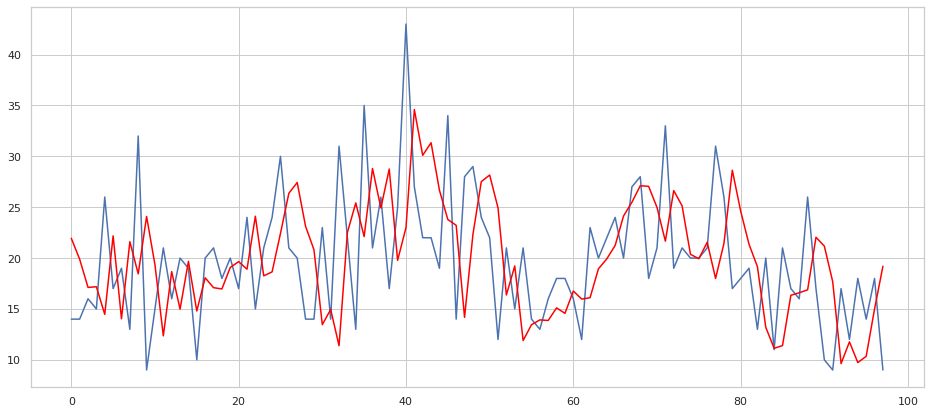

In [106]:
arima_MSE.append(arima_forescasting(series,5,2,0))

In [107]:
arima_MSE.append(arima_forescasting(series,5,2,5))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimi

Test MSE: 39.058


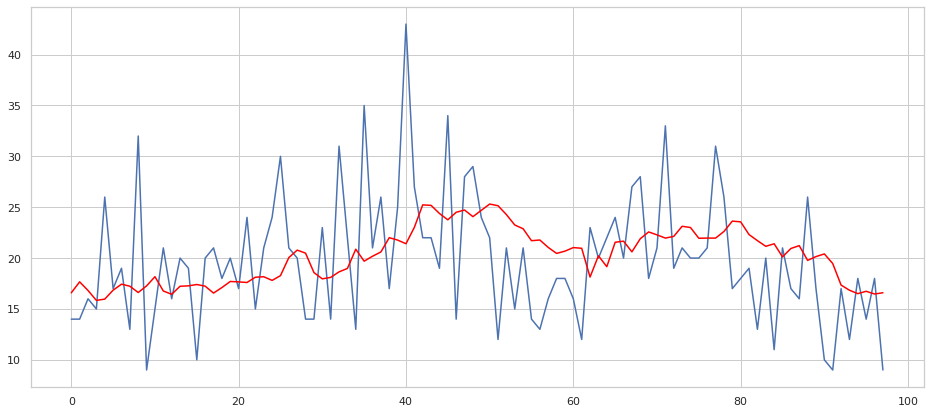

In [108]:
arima_MSE.append(arima_forescasting(series,0,2,5))

In [109]:
arima_MSE.append(arima_forescasting(series,5,2,10))

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_re

Test MSE: 39.141


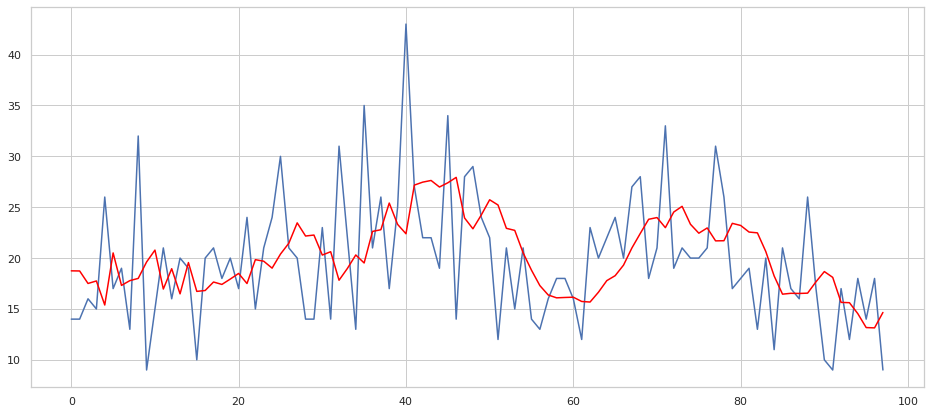

In [111]:
arima_MSE.append(arima_forescasting(series,5,2,1))

In [112]:
arima_MSE.append(arima_forescasting(series,5,2,2))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparam

LinAlgError: SVD did not converge

In [113]:
arima_MSE.append(arima_forescasting(series,5,2,3))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_pa

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [114]:
arima_MSE.append(arima_forescasting(series,5,2,4))

/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/avelezd/code/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [127]:
arima_MSE.append(arima_forescasting(series,6,0,46))

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

### Resultados ARIMA
Apliqué varias pruebas sobre el conjunto de datos con diferentes parámetros para ver cuales mejoraban el rendimiento del proceso predictivo, inicialmente probé los valores entregados por el método de Box-Jenkins y despues fui variando:

| Nro. | AR (p) | I (d) | MA (q) | MSE | Message |
| :-: | :-: | :-: | :-: | -: | :- |
| 1 | 5 | 0 | 10 | N/A | ValueError: On entry to DLASCL parameter number 4 had an illegal value |
| 2 | 5 | 0 | 0 | 39.342 |  |
| 3 | 5 | 1 | 0 | 38.735 | ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals "Check mle_retvals", ConvergenceWarning) |
| 4 | 0 | 0 | 10 | 42.604 |  |
| 5 | 5 | 1 | 10 | N/A | ValueError: The computed initial AR coefficients are not stationary You should induce stationarity, choose a different model order, or you can pass your own start_params. |
| 6 | 5 | 1 | 5 | N/A | ValueError: The computed initial AR coefficients are not stationary You should induce stationarity, choose a different model order, or you can pass your own start_params. |
| 7 | 5 | 0 | 5 | N/A | ValueError: On entry to DLASCL parameter number 4 had an illegal value |
| 8 | 5 | 2 | 0 | 54.714 |  |
| 9 | 5 | 2 | 5 | N/A | ValueError: The computed initial MA coefficients are not invertible You should induce invertibility, choose a different model order, or you can pass your own start_params. |
| 10 | 0 | 2 | 5 | 39.058 | ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals - HessianInversionWarning: Inverting hessian failed, no bse or cov_params available |
| 11 | 5 | 2 | 10 | N/A | ValueError: The computed initial AR coefficients are not stationary You should induce stationarity, choose a different model order, or you can pass your own start_params. |
| 12 | 5 | 2 | 1 | 39.141 | ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals |
| 13 | 5 | 2 | 2 | N/A | LinAlgError: SVD did not converge |
| 14 | 5 | 2 | 3 | N/A | ValueError: The computed initial MA coefficients are not invertible You should induce invertibility, choose a different model order, or you can pass your own start_params. |
| 15 | 5 | 2 | 4 | N/A | ValueError: The computed initial MA coefficients are not invertible You should induce invertibility, choose a different model order, or you can pass your own start_params. |

